In [1]:
# Cell 1 — Load processed data
import pandas as pd
import pickle
import numpy as np

train_df = pd.read_csv('../data/Processed/train.csv')
val_df = pd.read_csv('../data/Processed/val.csv')
test_df = pd.read_csv('../data/Processed/test.csv')

with open('../data/Processed/mlb.pkl', 'rb') as f:
    mlb = pickle.load(f)

with open('../data/Processed/top50_codes.pkl', 'rb') as f:
    top50_codes = pickle.load(f)

print(f"Train: {len(train_df):,}")
print(f"Val: {len(val_df):,}")
print(f"Test: {len(test_df):,}")
print("Data loaded successfully")

Train: 82,501
Val: 9,084
Test: 23,048
Data loaded successfully


In [2]:
import ast
from sklearn.preprocessing import MultiLabelBinarizer

# Cell 2 — Rebuild Label Matrices
# icd_codes column was saved as string, need to convert back to list
train_df['icd_codes'] = train_df['icd_codes'].apply(ast.literal_eval)
val_df['icd_codes'] = val_df['icd_codes'].apply(ast.literal_eval)
test_df['icd_codes'] = test_df['icd_codes'].apply(ast.literal_eval)

# Transform to binary matrices
y_train = mlb.transform(train_df['icd_codes'])
y_val = mlb.transform(val_df['icd_codes'])
y_test = mlb.transform(test_df['icd_codes'])

print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

y_train shape: (82501, 50)
y_val shape: (9084, 50)
y_test shape: (23048, 50)


Note using mlb.transform() not mlb.fit_transform() — important distinction. We already fitted the binarizer during preprocessing, so here we just transform using the existing mapping. This guarantees column consistency.

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Cell 3 — TF-IDF Vectorization
tfidf = TfidfVectorizer(
    max_features=50000,    # keep top 50k most important words
    min_df=5,              # ignore words appearing in fewer than 5 docs
    max_df=0.95,           # ignore words appearing in more than 95% of docs
    ngram_range=(1, 2),    # use single words AND two-word phrases
    sublinear_tf=True      # apply log normalization to term frequency
)

# Fit ONLY on training data
X_train = tfidf.fit_transform(train_df['text_clean'])
X_val = tfidf.transform(val_df['text_clean'])
X_test = tfidf.transform(test_df['text_clean'])

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\nVocabulary size: {len(tfidf.vocabulary_):,}")

X_train shape: (82501, 50000)
X_val shape: (9084, 50000)
X_test shape: (23048, 50000)

Vocabulary size: 50,000


Sample of how it actually looks 

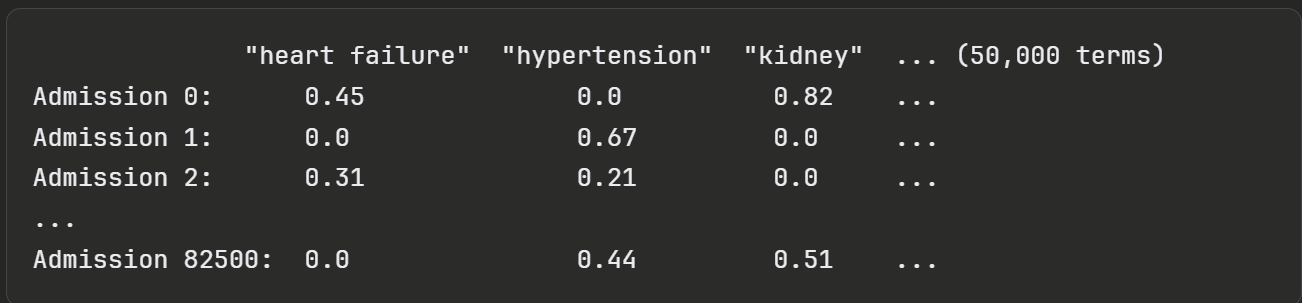

cellsEvery cell is a TF-IDF score.

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
import time

# Cell 4 — Train Logistic Regression Classifier
print("Training Logistic Regression...")
start = time.time()

lr_model = OneVsRestClassifier(
    LogisticRegression(
        max_iter=1000,
        C=1.0,
        solver='lbfgs'
    ),
    n_jobs=-1  # use all CPU cores
)

lr_model.fit(X_train, y_train)
elapsed = time.time() - start
print(f"Training complete in {elapsed:.1f} seconds")

Training Logistic Regression...
Training complete in 193.8 seconds


In [5]:
# Cell 5 — Evaluate on Validation Set
y_val_pred = lr_model.predict(X_val)

micro_f1 = f1_score(y_val, y_val_pred, average='micro')
macro_f1 = f1_score(y_val, y_val_pred, average='macro')
micro_precision = precision_score(y_val, y_val_pred, average='micro')
micro_recall = recall_score(y_val, y_val_pred, average='micro')

print("=== TF-IDF + Logistic Regression (Validation) ===")
print(f"Micro F1:        {micro_f1:.4f}")
print(f"Macro F1:        {macro_f1:.4f}")
print(f"Micro Precision: {micro_precision:.4f}")
print(f"Micro Recall:    {micro_recall:.4f}")

=== TF-IDF + Logistic Regression (Validation) ===
Micro F1:        0.5335
Macro F1:        0.4083
Micro Precision: 0.7816
Micro Recall:    0.4050


c:\Users\vinee\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The model is conservative — it only predicts when it's fairly confident (high precision) but misses a lot of true codes (low recall). 

In [6]:
# Cell 6 — Per Code F1 Analysis
per_code_f1 = f1_score(y_val, y_val_pred, average=None)

per_code_df = pd.DataFrame({
    'icd_code': top50_codes,
    'f1_score': per_code_f1
}).sort_values('f1_score', ascending=False)

print("Top 10 best predicted codes:")
print(per_code_df.head(10))
print("\nTop 10 worst predicted codes:")
print(per_code_df.tail(10))

Top 10 best predicted codes:
   icd_code  f1_score
10     E039  0.839895
0      E785  0.772260
11     Z794  0.768490
1       I10  0.741996
49     Z515  0.712375
5     I2510  0.708157
3      K219  0.699808
43     Z951  0.697500
9     Z7901  0.670819
22      Z66  0.670641

Top 10 worst predicted codes:
   icd_code  f1_score
15     E669  0.155303
41    G4700  0.137600
30     N189  0.113111
44     D696  0.096712
39    K5900  0.074703
32    Z8673  0.066773
20     Y929  0.065678
16     D649  0.051724
46   Y92230  0.038793
8    Z20822  0.000000


c:\Users\vinee\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
